<a href="https://colab.research.google.com/github/aidanshin/MCM2024Competition/blob/main/MCMC2024_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Using **LSTM Machine Learning in TensorFlow** and leveraging *finacnical technical analysis* methods, to predict **MOMENTUM swing and flow in Tennis.**:



>[Using LSTM Machine Learning in TensorFlow and leveraging finacnical technical analysis methods, to predict MOMENTUM swing and flow in Tennis.:](#scrollTo=_dhlqeN1QOtR)

>[LSTM Model Trained to predict point difference](#scrollTo=HiRFl-CSJC9Q)

>>[Packages and Libraries, TensorFlow with Keras ML API](#scrollTo=Ck1JKjxIO-IZ)

>>[Plot MACD and momentum for predicted and actual results and sensitivity training, features analysis](#scrollTo=0e8NEZYcsfNK)

>>[Momentum Curve from point_diff prediction](#scrollTo=2EWmyW8OLPdU)

>>[Permutation Importance Point Diff Model](#scrollTo=vMD9TBC8LhgE)

>>[Relative Error Analysis](#scrollTo=PhLutjjZLpt5)

>[RNN_LSTM Model for predicting momentum swing via MACD Indicator](#scrollTo=9a4ouCdnTxno)

>>[Permutation Importance MACD](#scrollTo=Y0sA-plAKyrj)

>>[Momentum Curve MACD](#scrollTo=BqGVGp9VK8hx)

>>[EXAMINE error distribution and visualize error per sample](#scrollTo=jEnwykDLwlox)

>>[Model analysis accuracy and error](#scrollTo=ZZ5EmPaAtZOB)

>[Model trained on MACD and EMA individually and predicted individually](#scrollTo=ic8ZZKEkGIMI)

>[Attempt at Modeling all Matches in data set simutaneously](#scrollTo=s67k3D-OL2ef)



# LSTM Model Trained to predict point difference

---
Most Sucesssful Model, used in **Analysis**

## Packages and Libraries, TensorFlow with Keras ML API

In [ ]:
!pip install pandas numpy scikit-learn tensorflow scikeras matplotlib



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout

<ipython-input-59-b84c277294f6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_data.drop(columns=['match_id', 'player1', 'player2', 'elapsed_time','elapsed_time_seconds','point_time_na','point_time'], axis=1, inplace=True)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renam

Best Parameters:  {'batch_size': 40, 'epochs': 1000}
Best Negative MAE:  0.40387239099160704
Mean Squared Error (MSE): 6.9877771769982235


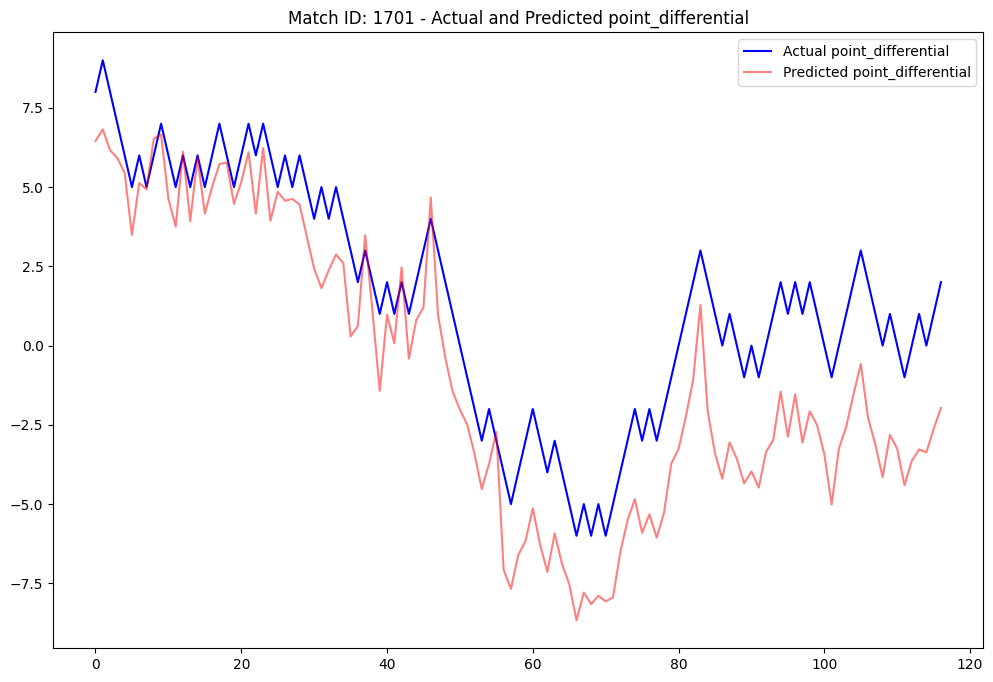

In [ ]:
# Load your dataset with pre-calculated MACD and EMA values
df = pd.read_csv('/content/data.csv')  # Adjust the file path accordingly

# Specify the percentage for training and testing
train_percentage = 0.65

# Get unique match IDs
unique_match_ids = df['match_id_int'].unique()

match_data = df[df['match_id_int'] == 1701]
match_data=match_data.dropna(axis=1)
# Drop unnecessary columns
match_data.drop(columns=['match_id', 'player1', 'player2', 'elapsed_time','elapsed_time_seconds','point_time_na','point_time'], axis=1, inplace=True)
# 'rally_count','speed_mph','serve_depth','serve_width','p2_distance_run','p1_distance_run','p1_break_pt_missed','p2_break_pt_missed'
match_data=match_data.dropna(axis=1)
# Determine the split index based on the specified percentage
split_index = int(len(match_data) * train_percentage)

# Split data into training and testing sets
train_data = match_data.iloc[:split_index]
test_data = match_data.iloc[split_index:]

# Preprocess the data for the current match
# Extract all columns for X_train and X_test
# Scale input data
scaler = MinMaxScaler()
X_train = train_data.values
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train = train_data[['point_differential']].values

X_test = test_data.values
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test = test_data[['point_differential']].values



# LSTM Model Definition
def create_lstm_model(input_shape, optimizer='adam', loss='mse'):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=25))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='linear'))  # Output layer with 1 unit for point_difference
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    return model

# Perform Grid Search for Hyperparameter Tuning
param_grid = {
    'batch_size': [40, 80],
    'epochs': [500, 1000],
}

# Pass input shape dynamically
lstm_model = KerasRegressor(build_fn=create_lstm_model, input_shape=(X_train.shape[1], X_train.shape[2]), verbose=0)
grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, error_score='raise', cv=3)
grid_result = grid_search.fit(X_train, y_train)

best_model = grid_result.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Print the best parameters and MAE for the current match
print(f"Best Parameters: ", grid_result.best_params_)
print("Best Negative MAE: ", grid_result.best_score_)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Print the MSE
print(f"Mean Squared Error (MSE): {mse}")

# Plotting point_difference plots for the current match
plt.figure(figsize=(12, 8))
plt.plot(y_test, label='Actual point_differential', color='blue')
plt.plot(y_pred, label='Predicted point_differential', color='red', alpha=0.5)
plt.title(f'Match ID: {1701} - Actual and Predicted point_differential')
plt.legend()
plt.show()


In [ ]:
# Load your dataset with pre-calculated MACD and EMA values
df = pd.read_csv('/content/data.csv')  # Adjust the file path accordingly

# Specify the percentage for training and testing
train_percentage = 0.8

# Get unique match IDs
unique_match_ids = df['match_id_int'].unique()

def MCAD(target, fwin, swin):
    values = np.array(target)
    small_ema = calcEMA(values, fwin)
    large_ema = calcEMA(values, swin)
    macd = np.subtract(small_ema, large_ema)
    return small_ema, large_ema, macd

def calcEMA(values, win):
    arr = []
    for i in range(0, win-1):
        arr.append(np.average(values[0:i+1]))
    for i in range(win-1, len(values)):
        if i == win-1:
            arr.append(np.average(values[0:win+1]))
        else:
            small_avg = arr[len(arr)-1]
            ema_calc = (values[i] - small_avg) * (2/(win+1)) + small_avg
            arr.append(ema_calc)
    return arr

match_data = df[df['match_id_int'] == 1701]
macd, signal, mag_momentum = MCAD(match_data['streak_differential'], 12, 26)
match_data['macd'] = macd
match_data['signal'] = signal
match_data['mag_momentum'] = mag_momentum
match_data = match_data.dropna(axis=1)

match_data.drop(columns=['match_id', 'player1', 'player2', 'elapsed_time','elapsed_time_seconds','point_time_na','point_time'], axis=1, inplace=True)

# Determine the split index based on the specified percentage
split_index = int(len(match_data) * train_percentage)

# Split data into training and testing sets
train_data = match_data.iloc[:split_index]
test_data = match_data.iloc[split_index:]

# Preprocess the data for the current match
# Extract all columns for X_train and X_test, including 'macd' and 'ema'
# Scale input data
scaler = MinMaxScaler()
# X_train = train_data.values
X_train = train_data.values  # Exclude 'macd' and 'signal'
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape[0], 1, -1)
y_train = train_data[['macd', 'signal']].values

# For testing
X_test = test_data.values  # Exclude 'macd' and 'signal'
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape[0], 1, -1)
y_test = test_data[['macd', 'signal']].values


# Reshape input data for LSTM

# LSTM Model Definition
def create_lstm_model(input_shape, optimizer='adam', loss='mse'):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=25))
    # model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(LSTM(units=25, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Dense(units=2, activation='linear'))  # Output layer with 2 units for MACD and EMA
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    return model

# Perform Grid Search for Hyperparameter Tuning
param_grid = {
    'batch_size': [40, 80],
    'epochs': [250, 450],
}

# Pass input shape dynamically
lstm_model = KerasRegressor(build_fn=create_lstm_model, input_shape=(X_train.shape[1], X_train.shape[2]), verbose=0)
grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, error_score='raise', cv=3)
grid_result = grid_search.fit(X_train, y_train)

best_model = grid_result.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Print the best parameters and MAE for the current match
print(f"Best Parameters: ", grid_result.best_params_)
print("Best Negative MAE: ", grid_result.best_score_)
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Print the MSE
print(f"Mean Squared Error (MSE): {mse}")

# Plotting MACD and EMA plots for the current match
plt.figure(figsize=(12, 8))
plt.plot(y_test[:, 0], label='Actual MACD', color='blue')
plt.plot(y_pred[:, 0], label='Predicted MACD', color='blue',alpha=0.50)
plt.plot(y_test[:, 1], label='Actual EMA', color='red')
plt.plot(y_pred[:, 1], label='Predicted EMA', color='red',alpha=0.5)
plt.title(f'Match ID: {1701} - Actual and Predicted MACD and EMA')
plt.legend()
plt.show()


##Plot MACD and momentum for predicted and actual results and sensitivity training, features analysis

# Momentum Curve from point_diff prediction

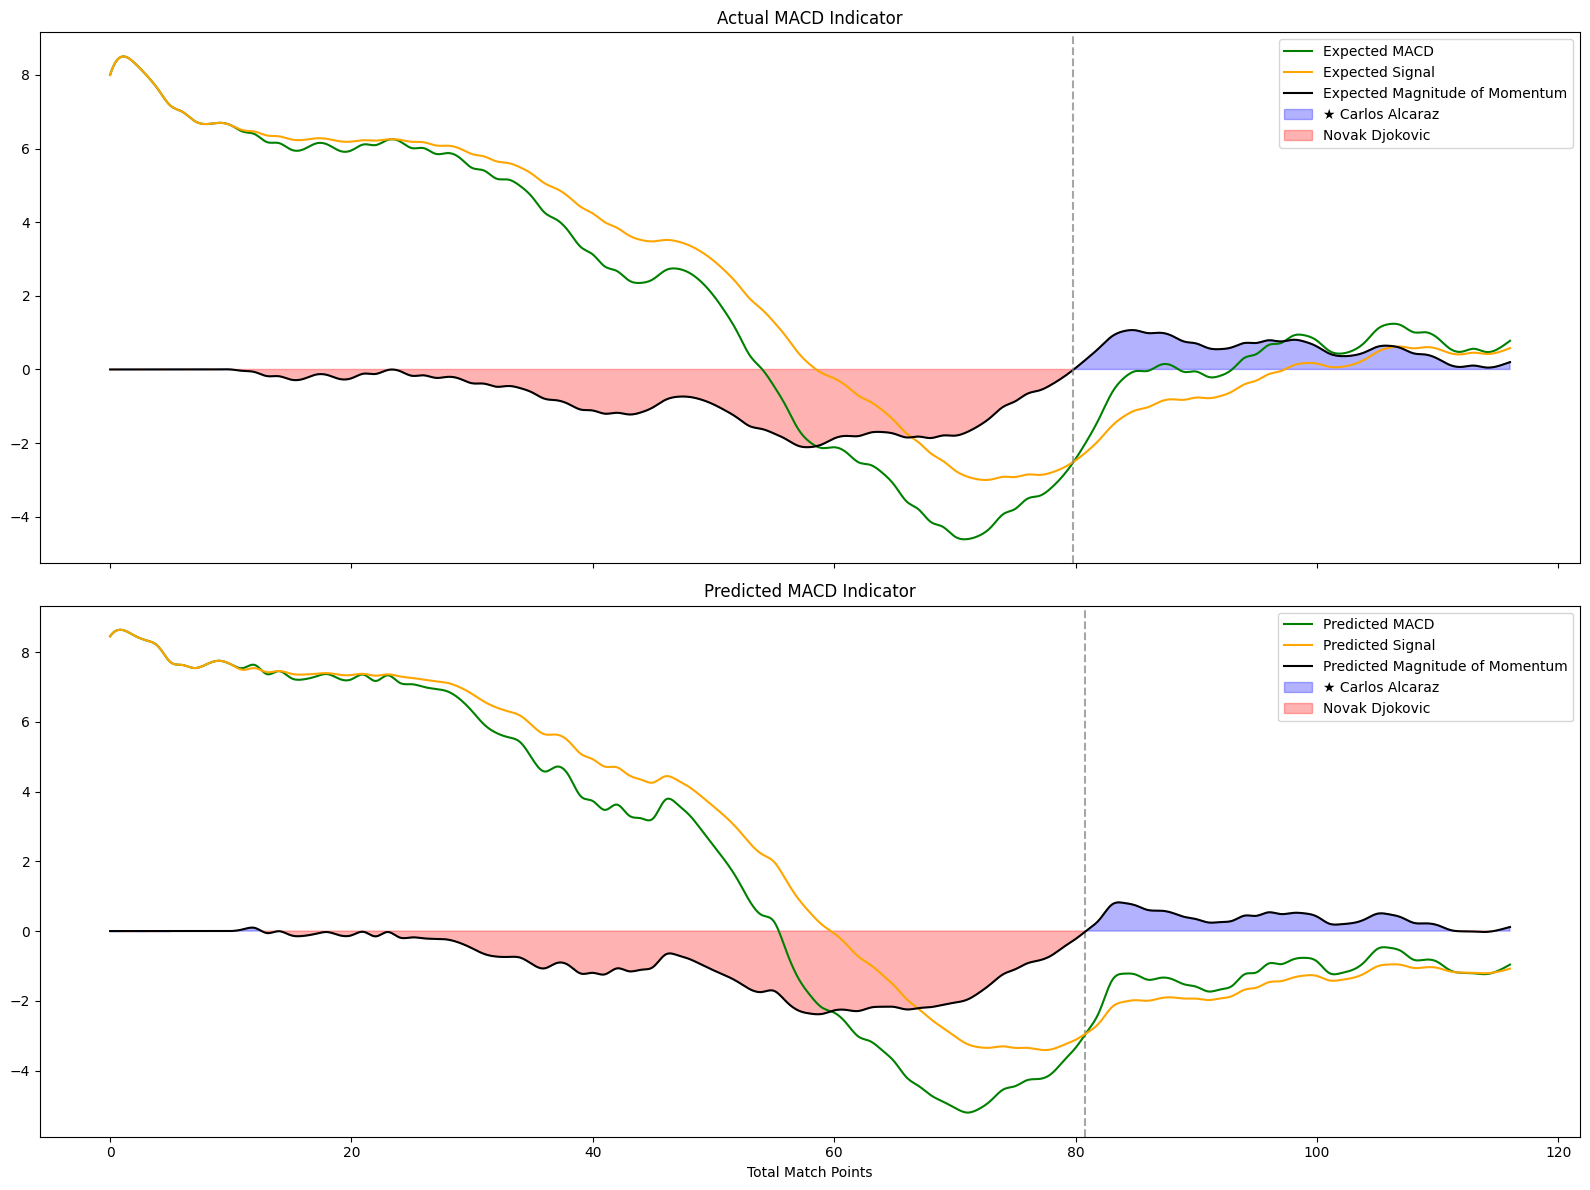

In [ ]:
from scipy.interpolate import make_interp_spline

def MCAD(target, actual, points, fwin, swin, winner, player_1, player_2):
    values = np.array(target)
    small_ema = calcEMA(values, fwin)
    large_ema = calcEMA(values, swin)
    macd = np.subtract(small_ema, large_ema)

    small_ema = smoothing(points,small_ema,3)
    large_ema = smoothing(points,large_ema,3)
    values = smoothing(points, values, 1)
    macd = smoothing(points, macd, 3)

    actual_values = np.array(actual)
    actual_small_ema = calcEMA(actual_values, fwin)
    actual_large_ema = calcEMA(actual_values, swin)
    actual_macd = np.subtract(actual_small_ema, actual_large_ema)

    actual_small_ema = smoothing(points,actual_small_ema,3)
    actual_large_ema = smoothing(points,actual_large_ema,3)
    actual_values = smoothing(points, actual_values, 1)
    actual_macd = smoothing(points, actual_macd, 3)

    points = np.linspace(points.min(), points.max(), 1000)

    if(winner == 1):
        player_1 = "★ " + player_1
    else:
        player_2 = "★ " + player_2

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)


    ax1.plot(points, actual_small_ema, color='green', label='Expected MACD')
    ax1.plot(points, actual_large_ema, color='orange', label='Expected Signal')
    ax1.plot(points, actual_macd, color='black', label='Expected Magnitude of Momentum')
    ax1.fill_between(points, actual_macd, color='blue', where=(actual_macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax1.fill_between(points, actual_macd, color='red', where=(actual_macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')



    intersection_indices_actual = np.where(np.diff(np.sign(actual_small_ema - actual_large_ema)))[0]
    intersection_indices_predicted = np.where(np.diff(np.sign(small_ema - large_ema)))[0]

    ax1.axvline(points[687], color='gray', linestyle='--', alpha=0.7)
    ax2.axvline(points[696], color='gray', linestyle='--', alpha=0.7)
    ax1.legend()
    ax1.set_title('Actual MACD Indicator')

    ax2.plot(points, small_ema, color='green', label='Predicted MACD')
    ax2.plot(points, large_ema, color='orange', label='Predicted Signal')
    ax2.plot(points, macd, color='black', label='Predicted Magnitude of Momentum')
    ax2.fill_between(points, macd, color='blue', where=(macd > 0), interpolate=True, alpha=0.3, label=f'{player_1}')
    ax2.fill_between(points, macd, color='red', where=(macd < 0), interpolate=True, alpha=0.3, label=f'{player_2}')

    ax2.legend()
    ax2.set_title('Predicted MACD Indicator')

    # Labeling and title for the entire figure
    plt.xlabel('Total Match Points')
    plt.tight_layout()
    plt.show()

def calcEMA(values, win):
    arr = []
    for i in range(0, win-1):
        arr.append(np.average(values[0:i+1]))
    for i in range(win-1, len(values)):
        if i == win-1:
            arr.append(np.average(values[0:win+1]))
        else:
            small_avg = arr[len(arr)-1]
            ema_calc = (values[i] - small_avg) * (2/(win+1)) + small_avg
            arr.append(ema_calc)
    return arr

def smoothing(x, y, k):
    spl = make_interp_spline(x, y, k=k)
    x_smooth = np.linspace(x.min(), x.max(), 1000)
    y_smooth = spl(x_smooth)
    return  y_smooth


MCAD([a+2 for val in y_pred for a in val], [a for val in y_test for a in val], np.arange(len(y_pred)), 12, 26, 1, "Carlos Alcaraz", "Novak Djokovic")



# Permutation Importance Point Diff Model

<ipython-input-78-c4fc4191ee5a>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Absolute_MSE_Change', y='Feature_Name', data=filtered_df, palette='viridis')


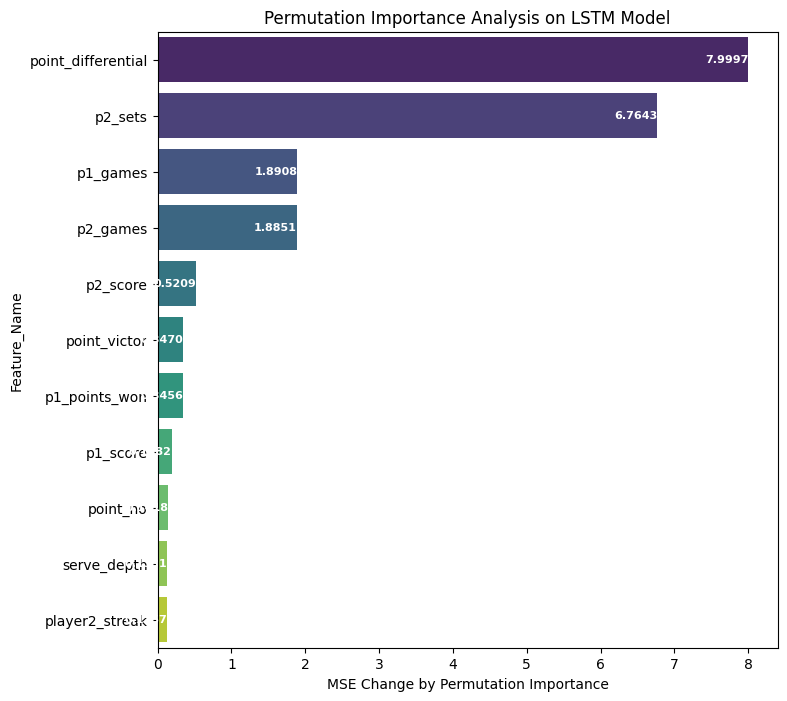

In [ ]:
import seaborn as sns
feature_names = train_data.columns.tolist()
# Calculate initial MSE
initial_mse = mean_squared_error(y_test, y_pred)

# Permutation Importance Analysis
perm_importances = []

for i in range(X_test.shape[2]):
    # Create a copy of X_test to avoid modifying the original data
    X_test_permuted = X_test.copy()

    # Permute the feature at index i
    X_test_permuted[:, 0, i] = np.random.permutation(X_test[:, 0, i])

    # Make predictions on permuted data
    y_pred_permuted = grid_search.predict(X_test_permuted)

    # Calculate MSE for permuted data
    permuted_mse = mean_squared_error(y_test, y_pred_permuted)

    # Calculate the change in MSE
    mse_change = permuted_mse - initial_mse

    # Store the feature index, name, and change in MSE
    perm_importances.append((i, feature_names[i], mse_change))

# Sort the results by the change in MSE
perm_importances.sort(key=lambda x: x[2], reverse=True)

# Print the magnitudes for each feature
# for importance in perm_importances:
#     print(f"Feature: {importance[1]}, Magnitude: {abs(importance[2])}")


perm_importances_df = pd.DataFrame(perm_importances, columns=['Feature_Index', 'Feature_Name', 'MSE_Change'])

# Calculate the absolute values of MSE changes
perm_importances_df['Absolute_MSE_Change'] =(perm_importances_df['MSE_Change'])

perm_importances_df.set_index('Feature_Name', inplace=True)
# Filter features with correlation values greater than or equal to 0.003
# Drop 'macd', 'signal', and 'mag_momentum' columns
filtered_df = perm_importances_df.drop(['point_differential'], axis=0)

# Filter features with correlation values greater than or equal to 0.003
filtered_df = perm_importances_df[perm_importances_df['Absolute_MSE_Change'] >= 0.07]

# Create a heatmap with annotations
plt.figure(figsize=(8, 8))
sns.barplot(x='Absolute_MSE_Change', y='Feature_Name', data=filtered_df, palette='viridis')
plt.yticks(rotation=0)
plt.xlabel('MSE Change by Permutation Importance')
plt.title('Permutation Importance Analysis on LSTM Model')

# Annotate each cell with its feature name and magnitude of MSE
for i, (feature_name, mse_change) in enumerate(zip(filtered_df.index, filtered_df['Absolute_MSE_Change'])):
    plt.text(mse_change + 0.001, i, f"{mse_change:.4f}", ha='right', va='center', color='white', fontsize=8, fontweight='bold')
plt.show()

## Relative Error Analysis

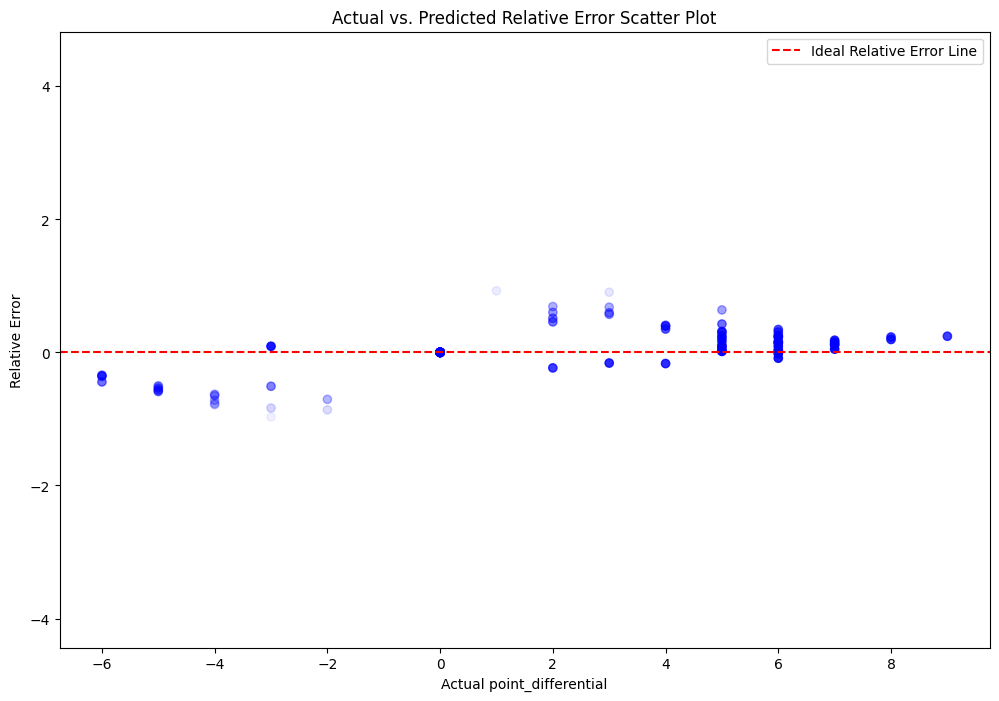

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate relative errors
y_test_float = y_test.astype(float)
y_pred_float = y_pred.astype(float)
relative_errors = np.divide((y_test_float - y_pred_float), y_test_float, out=np.zeros_like(y_test_float), where=y_test_float != 0)

# Calculate the distance from the ideal line
distance_from_ideal = np.abs(relative_errors)

# Calculate opacity based on the distance from the ideal line
max_opacity = 1.0
opacity = 1 - np.clip(distance_from_ideal, 0, max_opacity) / max_opacity

# Plotting Scatter Plot with varying opacity
plt.figure(figsize=(12, 8))
plt.scatter(y_test, relative_errors, alpha=opacity, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Ideal Relative Error Line')
plt.title('Actual vs. Predicted Relative Error Scatter Plot')
plt.xlabel('Actual point_differential')
plt.ylabel('Relative Error')
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error
y_test_float = y_test.astype(float)
y_pred_float = y_pred.astype(float)
def calculate_avg_metrics(y_true, y_pred):


    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    y_true_float = y_true.astype(float)
    y_pred_float = y_pred.astype(float)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true_float, y_pred_float))

    # Calculate Relative Error Percentage
    relative_errors = np.divide((y_true_float - y_pred_float), y_true_float, out=np.zeros_like(y_true_float), where=y_true_float != 0)
    avg_relative_error = np.abs(relative_errors).mean() * 100

    return rmse, avg_relative_error

# Example usage:
rmse, avg_relative_error = calculate_avg_metrics(y_test, y_pred)
print(f"Average RMSE: {rmse}")
print(f"Average Relative Error Percentage: {avg_relative_error}%")


Average RMSE: 2.6434404054183296
Average Relative Error Percentage: 106.0355615298859%


##RNN_LSTM Model for predicting momentum swing via MACD Indicator


---
Model Was successful, however not accurate enough. Predicted first half of data poorly but preformed well on the second half.



# Permutation Importance MACD

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

In [ ]:
import seaborn as sns
feature_names = train_data.columns.tolist()
# Calculate initial MSE
initial_mse = mean_squared_error(y_test, y_pred)

# Permutation Importance Analysis
perm_importances = []

for i in range(X_test.shape[2]):
    # Create a copy of X_test to avoid modifying the original data
    X_test_permuted = X_test.copy()

    # Permute the feature at index i
    X_test_permuted[:, 0, i] = np.random.permutation(X_test[:, 0, i])

    # Make predictions on permuted data
    y_pred_permuted = grid_search.predict(X_test_permuted)

    # Calculate MSE for permuted data
    permuted_mse = mean_squared_error(y_test, y_pred_permuted)

    # Calculate the change in MSE
    mse_change = permuted_mse - initial_mse

    # Store the feature index, name, and change in MSE
    perm_importances.append((i, feature_names[i], mse_change))

# Sort the results by the change in MSE
perm_importances.sort(key=lambda x: x[2], reverse=True)

# Print the magnitudes for each feature
# for importance in perm_importances:
#     print(f"Feature: {importance[1]}, Magnitude: {abs(importance[2])}")


perm_importances_df = pd.DataFrame(perm_importances, columns=['Feature_Index', 'Feature_Name', 'MSE_Change'])

# Calculate the absolute values of MSE changes
perm_importances_df['Absolute_MSE_Change'] =(perm_importances_df['MSE_Change'])

perm_importances_df.set_index('Feature_Name', inplace=True)
# Filter features with correlation values greater than or equal to 0.003
# Drop 'macd', 'signal', and 'mag_momentum' columns
filtered_df = perm_importances_df.drop(['macd', 'signal', 'mag_momentum'], axis=0)

# Filter features with correlation values greater than or equal to 0.003
filtered_df = filtered_df[filtered_df['Absolute_MSE_Change'] >= 0.003]

# Create a heatmap with annotations
plt.figure(figsize=(8,8))
sns.barplot(x='Absolute_MSE_Change', y='Feature_Name', data=filtered_df, palette='viridis')
plt.yticks(rotation=0)
plt.xlabel('Momentum Correlation by Absolute MSE')
plt.title('Correlation Analysis by Permutation Importance on LSTM Model')

# Annotate each cell with its feature name
for i, feature_name in enumerate(perm_importances_df.index):
    plt.text(0, i + 0.5, feature_name, ha='right', va='center', color='white', fontsize=8, fontweight='bold')

plt.show()

# Momentum Curve MACD

In [ ]:
from scipy.interpolate import make_interp_spline

def smoothing(x, y, k):
    spl = make_interp_spline(x, y, k=k)
    x_smooth = np.linspace(x.min(), x.max(), 300)
    y_smooth = spl(x_smooth)
    return y_smooth

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

predicted_macd = y_pred[:, 0]
predicted_ema = y_pred[:, 1]

actual_macd = y_test[:, 0]
actual_ema = y_test[:, 1]

# Generate x values for smoothing
x = np.arange(len(predicted_macd))
x_smooth = np.linspace(x.min(), x.max(), 300)

# Smooth the curves using interpolation
predicted_macd_smooth = smoothing(x, predicted_macd, k=3)
predicted_ema_smooth = smoothing(x, predicted_ema, k=3)
actual_macd_smooth = smoothing(x, actual_macd, k=3)
actual_ema_smooth = smoothing(x, actual_ema, k=3)

difference = predicted_macd_smooth - predicted_ema_smooth
actual_difference = actual_macd_smooth - actual_ema_smooth

ax1.plot(x_smooth, actual_macd_smooth, color='green', label='MACD')
ax1.plot(x_smooth, actual_ema_smooth, color='orange', label='Signal')
ax1.plot(x_smooth, actual_difference, color='black', label='Magnitude of Momentum', alpha=0.5)
ax1.fill_between(x_smooth, actual_difference, color='blue', where=(actual_difference > 0), interpolate=True, alpha=0.3, label='Positive Difference')
ax1.fill_between(x_smooth, actual_difference, color='red', where=(actual_difference < 0), interpolate=True, alpha=0.3, label='Negative Difference')

ax1.legend()
ax1.set_title('MACD actual')

ax2.plot(x_smooth, predicted_macd_smooth, color='green', label='Predicted MACD')
ax2.plot(x_smooth, predicted_ema_smooth, color='orange', label='Predicted Signal')
ax2.plot(x_smooth, difference, color='black', label='Magnitude of Momentum', alpha=0.5)
ax2.fill_between(x_smooth, difference, color='blue', where=(difference > 0), interpolate=True, alpha=0.3, label='Positive Difference')
ax2.fill_between(x_smooth, difference, color='red', where=(difference < 0), interpolate=True, alpha=0.3, label='Negative Difference')

# Mark the intersection points
intersection_indices_actual = np.where(np.diff(np.sign(actual_macd_smooth - actual_ema_smooth)))[0]
intersection_indices_predicted = np.where(np.diff(np.sign(predicted_macd_smooth - predicted_ema_smooth)))[0]

for idx in intersection_indices_actual:
    ax1.axvline(x=x_smooth[idx], color='gray', linestyle='--', alpha=0.7)

for idx in intersection_indices_predicted:
    ax2.axvline(x=x_smooth[idx], color='gray', linestyle='--', alpha=0.7)

# Update legend labels for both subplots
legend1 = ax1.legend()
for text in legend1.get_texts():
    if text.get_text() == 'Positive Difference':
        text.set_text('Player 1 Momentum')
    elif text.get_text() == 'Negative Difference':
        text.set_text('Player 2 Momentum')

legend2 = ax2.legend()
for text in legend2.get_texts():
    if text.get_text() == 'Positive Difference':
        text.set_text('Player 1 Momentum')
    elif text.get_text() == 'Negative Difference':
        text.set_text('Player 2 Momentum')

ax2.set_title('MACD predicted')
ax1.set_title('MACD actual')

# Labeling and title for the entire figure
plt.xlabel('Number of Points')
plt.tight_layout()
plt.show()



## EXAMINE error distribution and visualize error per sample

---
MACD MODEL




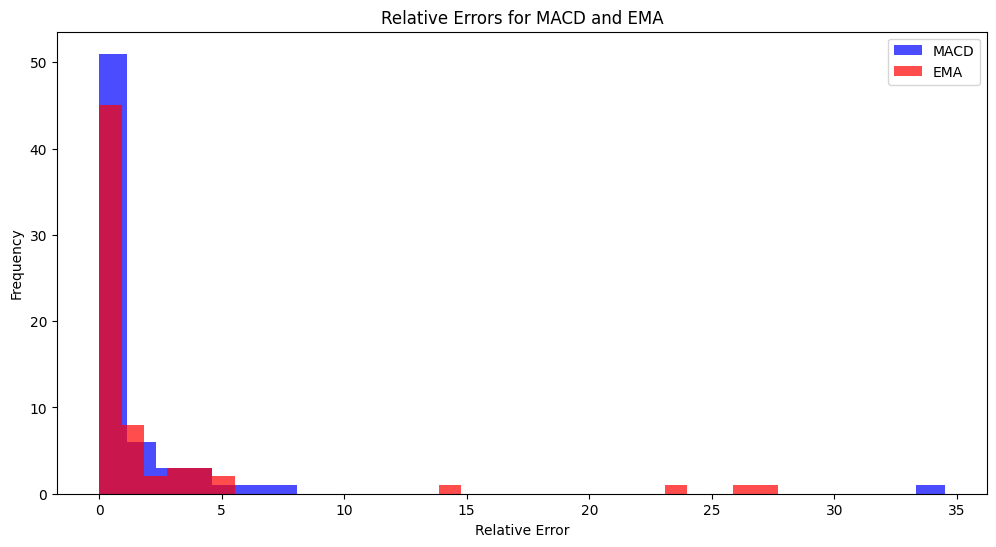

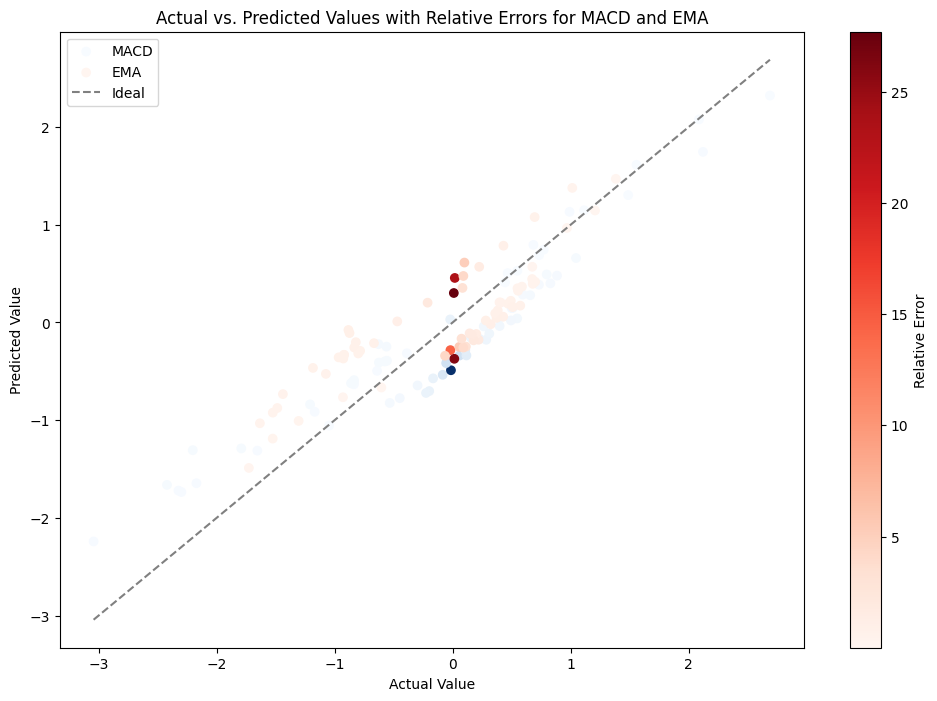

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate relative errors
relative_errors = np.abs((y_test - y_pred) / y_test)

# Plotting error distributions
plt.figure(figsize=(12, 6))

# Plotting histograms of relative errors for MACD and EMA on the same plot
plt.hist(relative_errors[:, 0], bins=30, color='blue', alpha=0.7, label='MACD')
plt.hist(relative_errors[:, 1], bins=30, color='red', alpha=0.7, label='EMA')

plt.title('Relative Errors for MACD and EMA')
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Visualizing errors on a per-sample basis
plt.figure(figsize=(12, 8))

# Scatter plot of actual vs. predicted values with color-coded relative errors for MACD and EMA
plt.scatter(y_test[:, 0], y_pred[:, 0], c=relative_errors[:, 0], cmap='Blues', label='MACD', alpha=1)
plt.scatter(y_test[:, 1], y_pred[:, 1], c=relative_errors[:, 1], cmap='Reds', label='EMA', alpha=1)

plt.plot([min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())],
         [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())], '--', color='gray', label='Ideal')

legend = plt.legend()
for text in legend.get_texts():
    text.set_alpha(1.0)  # Set alpha to 1.0 for full opacity

plt.title('Actual vs. Predicted Values with Relative Errors for MACD and EMA')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.colorbar(label='Relative Error')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample relative errors (replace with your actual relative errors)
relative_errors = np.array([1, 2, 3, 4, 40])

# Calculate median relative error
median_relative_error = np.median(np.abs(relative_errors))

# Print median relative error
print(f"Median Relative Error: {median_relative_error}")


Median Relative Error: 3.0


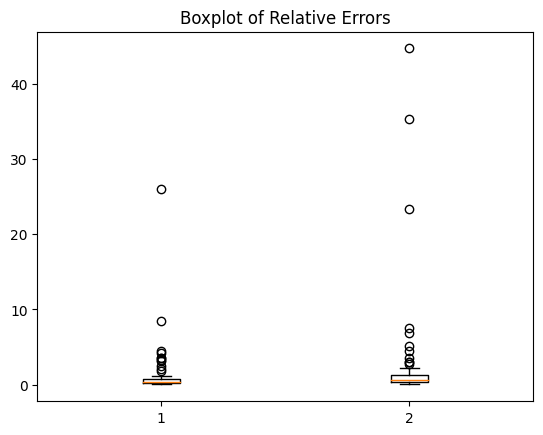

In [ ]:
import numpy as np
from scipy import stats
relative_errors = np.abs((y_test - y_pred) / y_test)

z_scores = np.abs(stats.zscore(relative_errors))
threshold = 3  # Adjust this threshold based on your requirements
outliers = np.where(z_scores > threshold)[0]

plt.boxplot(relative_errors)
plt.title('Boxplot of Relative Errors')
plt.show()



##Model analysis accuracy and error

---
MACD MODEL



In [ ]:
import numpy as np

# Function to calculate relative error and error percentage
def calculate_relative_error(actual, predicted):
    relative_error = np.abs(predicted - actual) / np.abs(actual)
    error_percentage = relative_error * 100
    return relative_error, error_percentage


# Calculate relative error and error percentage
relative_error, error_percentage = calculate_relative_error(y_test, y_pred)

# Calculate and print averages
average_relative_error = np.mean(relative_error)
average_error_percentage = np.mean(error_percentage)

print("Average Relative Error:", average_relative_error)
print("Average Error Percentage:", average_error_percentage)



Average Relative Error: 1.9639619972380398
Average Error Percentage: 196.396199723804


## Model trained on MACD and EMA individually and predicted individually
---
Sub Optimal Results.



In [ ]:
# # Load your dataset with pre-calculated MACD and EMA values
# df = pd.read_csv('/content/data.csv')  # Adjust the file path accordingly

# # Specify the percentage for training and testing
# train_percentage = 0.8

# # Get unique match IDs
# unique_match_ids = df['match_id_int'].unique()

# def MCAD(target, fwin, swin):
#     values = np.array(target)
#     small_ema = calcEMA(values, fwin)
#     large_ema = calcEMA(values, swin)
#     macd = np.subtract(small_ema, large_ema)
#     return small_ema, large_ema, macd

# def calcEMA(values, win):
#     arr = []
#     for i in range(0, win-1):
#         arr.append(np.average(values[0:i+1]))
#     for i in range(win-1, len(values)):
#         if i == win-1:
#             arr.append(np.average(values[0:win+1]))
#         else:
#             small_avg = arr[len(arr)-1]
#             ema_calc = (values[i] - small_avg) * (2/(win+1)) + small_avg
#             arr.append(ema_calc)
#     return arr

# match_data = df[df['match_id_int'] == 1701]
# macd, signal, mag_momentum = MCAD(match_data['streak_differential'], 12, 26)
# match_data['macd'] = macd
# match_data['signal'] = signal
# match_data['mag_momentum'] = mag_momentum
# match_data = match_data.dropna(axis=1)

# match_data.drop(columns=['match_id', 'player1', 'player2', 'elapsed_time','elapsed_time_seconds','point_time_na','point_time'], axis=1, inplace=True)

# # Determine the split index based on the specified percentage
# split_index = int(len(match_data) * train_percentage)

# # Split data into training and testing sets
# train_data = match_data.iloc[:split_index]
# test_data = match_data.iloc[split_index:]

# # Preprocess the data for the current match
# # Extract all columns for X_train and X_test, including 'macd' and 'ema'
# # Scale input data
# scaler = MinMaxScaler()
# X_train = train_data.values
# X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# y_train_macd = train_data['macd'].values
# y_train_ema = train_data['signal'].values

# X_test = test_data.values
# X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
# y_test_macd = test_data['macd'].values
# y_test_ema = test_data['signal'].values

# # Define two separate LSTM models for MACD and EMA
# def create_lstm_model(input_shape, optimizer='adam', loss='mse'):
#     model = Sequential()
#     model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(LSTM(units=50, return_sequences=True))
#     model.add(LSTM(units=25))
#     model.add(Dropout(0.5))
#     model.add(Dense(units=1, activation='linear'))  # Output layer with 1 unit for either MACD or EMA
#     model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
#     return model

# # Train the model for MACD
# lstm_model_macd = KerasRegressor(build_fn=create_lstm_model, input_shape=(X_train.shape[1], X_train.shape[2]), verbose=0)
# grid_search_macd = GridSearchCV(estimator=lstm_model_macd, param_grid=param_grid, error_score='raise', cv=3)
# grid_result_macd = grid_search_macd.fit(X_train, y_train_macd)

# # Get the best MACD model
# best_model_macd = grid_result_macd.best_estimator_

# # Train the model for EMA
# lstm_model_ema = KerasRegressor(build_fn=create_lstm_model, input_shape=(X_train.shape[1], X_train.shape[2]), verbose=0)
# grid_search_ema = GridSearchCV(estimator=lstm_model_ema, param_grid=param_grid, error_score='raise', cv=3)
# grid_result_ema = grid_search_ema.fit(X_train, y_train_ema)

# # Get the best EMA model
# best_model_ema = grid_result_ema.best_estimator_

# # Predict on the test set for MACD
# y_pred_macd = best_model_macd.predict(X_test)

# # Predict on the test set for EMA
# y_pred_ema = best_model_ema.predict(X_test)

# # Combine the predictions for MACD and EMA
# y_pred_combined = np.column_stack((y_pred_macd, y_pred_ema))

# # Print the best parameters and MAE for each model
# print("Best Parameters (MACD): ", grid_result_macd.best_params_)
# print("Best Negative MAE (MACD): ", grid_result_macd.best_score_)

# print("Best Parameters (EMA): ", grid_result_ema.best_params_)
# print("Best Negative MAE (EMA): ", grid_result_ema.best_score_)

# # Calculate MSE for each target variable
# mse_macd = mean_squared_error(y_test_macd, y_pred_macd)
# mse_ema = mean_squared_error(y_test_ema, y_pred_ema)

# # Print the MSE for each target variable
# print(f"Mean Squared Error (MACD): {mse_macd}")
# print(f"Mean Squared Error (EMA): {mse_ema}")


# # Plotting MACD and EMA plots for the current match
# plt.figure(figsize=(12, 8))
# plt.plot(y_test_macd, label='Actual MACD', color='blue')
# plt.plot(y_pred_macd, label='Predicted MACD', color='blue', alpha=0.50)
# plt.plot(y_test_ema, label='Actual EMA', color='red')
# plt.plot(y_pred_ema, label='Predicted EMA', color='red', alpha=0.50)
# plt.title(f'Match ID: {1701} - Actual and Predicted MACD and EMA')
# plt.legend()
# plt.show()


# Attempt at Modeling all Matches in data set simutaneously

---

Previous models were trained and tested on a per match basis and fed a match ID.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming necessary imports are already done

def process_match(match_id, df):
    try:
        match_data = df[df['match_id_int'] == match_id]

        # Drop unnecessary columns
        match_data.drop(columns=['match_id', 'player1', 'player2', 'elapsed_time', 'elapsed_time_seconds', 'point_time_na', 'point_time'], axis=1, inplace=True)

        # Drop columns with NaN values
        match_data = match_data.dropna(axis=1)

        # Determine the split index based on the specified percentage
        split_index = int(len(match_data) * train_percentage)

        # Split data into training and testing sets
        train_data = match_data.iloc[:split_index]
        test_data = match_data.iloc[split_index:]

        # Preprocess the data for the current match
        X_train = train_data.values
        X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        y_train = train_data[['point_differential']].values

        X_test = test_data.values
        X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
        y_test = test_data[['point_differential']].values

        # Perform Grid Search for Hyperparameter Tuning
        grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, error_score='raise', cv=3)
        grid_result = grid_search.fit(X_train, y_train)

        best_model = grid_result.best_estimator_

        # Predict on the test set
        y_pred = best_model.predict(X_test)

        # Print the best parameters and MAE for the current match
        print(f"Match ID: {match_id}")
        print(f"Best Parameters: ", grid_result.best_params_)
        print("Best Negative MAE: ", grid_result.best_score_)

        # Calculate MSE
        mse = mean_squared_error(y_test, y_pred)

        # Print the MSE
        print(f"Mean Squared Error (MSE): {mse}")

        # Plotting point_difference plots for the current match
        plt.figure(figsize=(12, 8))
        plt.plot(y_test, label='Actual point_differential', color='blue')
        plt.plot(y_pred, label='Predicted point_differential', color='red', alpha=0.5)
        plt.title(f'Match ID: {match_id} - Actual and Predicted point_differential')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error processing Match ID {match_id}: {e}")

# Loop over all unique match IDs
for match_id in unique_match_ids:
    process_match(match_id, df)
    game = df[df['match_id_int'] == match_id]
    MCAD([a+2 for val in y_pred for a in val], [a for val in y_test for a in val], np.arange(len(y_pred)), 12, 26, game['winners'].min(), game['player1'].min(), game['player2'].min())

